<a href="https://colab.research.google.com/github/vlad-danaila/machine-learning-workout/blob/master/Exercise_3_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip3 install torch torchvision

In [4]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

Cloning into 'ants_and_bees'...
remote: Enumerating objects: 408, done.
remote: Total 408 (delta 0), reused 0 (delta 0), pack-reused 408
Receiving objects: 100% (408/408), 45.03 MiB | 46.06 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [0]:
import torch as t
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt

**Loading Data**

In [0]:
batch_size = 32

transform_train = tv.transforms.Compose([
  tv.transforms.Resize((128, 128)),
  tv.transforms.RandomAffine(degrees = 30, shear = 30, scale = (.8, 1.2)),
  tv.transforms.RandomHorizontalFlip(),
  tv.transforms.ColorJitter(brightness=.1, contrast=.1, saturation=.1),
  tv.transforms.ToTensor()                                     
])
transform_eval = tv.transforms.Compose([
  tv.transforms.Resize((256, 256)),
  tv.transforms.ToTensor()                                     
])

dataset_train = tv.datasets.ImageFolder('/content/ants_and_bees/train', transform = transform_train)
dataset_eval = tv.datasets.ImageFolder('/content/ants_and_bees/val', transform = transform_eval)

loader_train = t.utils.data.dataloader.DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
loader_eval = t.utils.data.dataloader.DataLoader(dataset_eval, batch_size = batch_size, shuffle = False)

In [0]:
def to_numpy(x):
  return x.cpu().detach().numpy()

def plot_img(img, prediction, label):
  img = to_numpy(img).transpose(1, 2, 0)
  plt.imshow(img)
  plt.title('ant' if prediction == 0 else 'bee', color = 'green' if prediction == label else 'red')

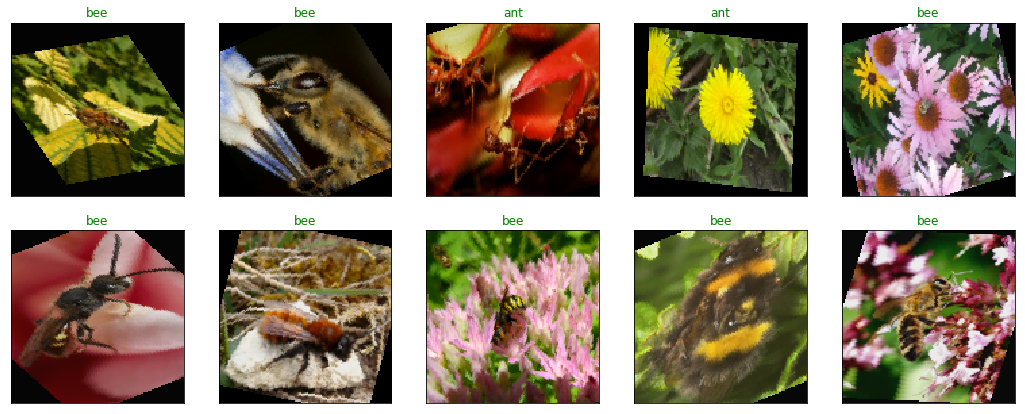

In [272]:
imgs, labels = next(iter(loader_train))
fig = plt.figure(figsize = (18, 7))

for i in range(10):
  fig.add_subplot(2, 5, i + 1, xticks = [], yticks = [])
  plot_img(imgs[i], labels[i], labels[i])

**Define Model**

In [0]:
model = tv.models.vgg16(pretrained = True)
for param in model.parameters():
  param.requires_grad = False
model.classifier[6] = t.nn.Linear(model.classifier[6].in_features, 1) # by default requires grad is True
model = model.cuda()

**Train**

In [0]:
def accuracy(y_pred, y):
  return t.sum((y_pred > .5) == y.byte()).item() / len(y)

def train():
  total_loss = 0
  total_acc = 0
  for x, y in loader_train:
    x, y = x.cuda(), y.cuda().float()
    y_pred = model.forward(x).squeeze(1)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss
    total_acc += accuracy(y_pred, y)
  loss_train.append(total_loss / len(loader_train))
  accuracy_train.append(total_acc / len(loader_train))

def evaluate():
  total_loss = 0
  total_acc = 0
  for x, y in loader_eval:
    x, y = x.cuda(), y.cuda().float()
    y_pred = model.forward(x).squeeze(1)
    loss = loss_fn(y_pred, y)
    total_loss += loss
    total_acc += accuracy(y_pred, y)
  loss_eval.append(total_loss / len(loader_eval))
  accuracy_eval.append(total_acc / len(loader_eval))

In [275]:
epochs = 10
optimizer = t.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = t.nn.BCEWithLogitsLoss()

loss_train = []
loss_eval = []
accuracy_train = []
accuracy_eval = []

for epoch in range(epochs):
  print('Epochs', epoch + 1)
  model.train()
  train()
  model.eval()
  with t.no_grad():
    evaluate()

Epochs 1
Epochs 2
Epochs 3
Epochs 4
Epochs 5
Epochs 6
Epochs 7
Epochs 8
Epochs 9
Epochs 10


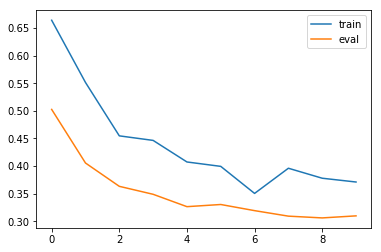

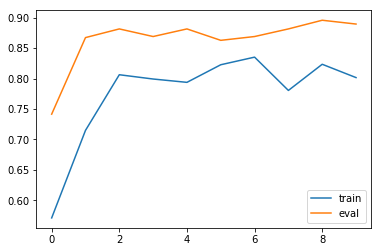

Eval accuracy is 0.8895


In [276]:
plt.plot(range(len(loss_train)), loss_train, label = 'train')
plt.plot(range(len(loss_eval)), loss_eval, label = 'eval')
plt.legend()
plt.show()

plt.plot(range(len(accuracy_train)), accuracy_train, label = 'train')
plt.plot(range(len(accuracy_eval)), accuracy_eval, label = 'eval')
plt.legend()
plt.show()

print('Eval accuracy is', accuracy_eval[-1])